# Mortos no massacre de Gaza - 2023-2024

Voltar ao [índice](../00_indice.ipynb)

Neste notebook, ajustamos um modelo estatístico para descrever a distribuição de mortes em Gaza por 
idade e sexo decorrentes de ataques israelenses após o ataque do Hamas em 7 de outubro de 2023.

**Objetivos** 

Verificar a fração de mortes em Gaza que decorrem de ataques indiscriminados, que acertam toda a população 
(por ex., com bombas poderosas em áreas residenciais).

**Você vai aprender:**
* O processo de criação de um modelo estatístico motivado pela realidade.
* Uma introdução à estatística Bayesiana.
* Como ajustar modelos (i.e. definir os melhores parâmetros) usando a técnica de Monte Carlo com Cadeias de Markov (MCMC). 

In [3]:
import pandas as pd
import matplotlib.pyplot as pl
import scipy as sc
import numpy as np
import sys
import json

sys.path.append("../80_material-complementar/")
import auxiliar.dataframes as ad
import auxiliar.graficos as ag

import suplementar as su

### Anotações

Dados auxiliares: <https://www.cia.gov/the-world-factbook/countries/gaza-strip/>: _"the military wing of HAMAS has an estimated 20-25,000 fighters (2023)"_

## 1. Carrega os dados

Os dados, originários do Ministério da Saúde de Gaza, foram obtidos do site 
[techforpalestine.org](https://data.techforpalestine.org) e foram tratados no notebook 
[20_exploracao_limpeza_mortos-gaza.ipynb](20_exploracao_limpeza_mortos-gaza.ipynb) (aqui utilizamos os dados já tratados). 
Eles advém da lista de pessoas mortas identificadas em hospitais. Segundo o site, a última atualização foi em 5 de janeiro para hospitais que reportam do Sul de Gaza e 2 de novembro para os que reportam do Norte. Além disso, para essa lista:
* As pessoas desaparecidas e os corpos dos que ficaram presos sob os escombros não foram contabilizados.
* As pessoas não identificadas que chegaram aos hospitais não foram contabilizadas.
* As pessoas não identificadas cujos corpos foram entregues pela ocupação israelense não foram contabilizadas.
* Não foram contabilizados aqueles que foram enterrados por suas famílias sem passar pelos hospitais.
* As vítimas em Gaza e no Norte de Gaza não foram contabilizadas após a data de encerramento do sistema de informação em Novembro.

Apesar de desatualizado e incompleto, esses dados têm três vantagens frente a outros:
1. advém de uma fonte confiável (veja reportagens da agência [Reuters](https://www.reuters.com/world/middle-east/how-many-palestinians-have-died-gaza-war-how-will-counting-continue-2023-12-06/) e da [Associated Press](https://apnews.com/article/israel-hamas-war-gaza-health-ministry-health-death-toll-59470820308b31f1faf73c703400b033), e o estudo da revista médica [The Lancet](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(23)02640-5/fulltext));
2. possuem registro de idade das pessoas mortas; e
3. são conservadores na estimativa de crianças e mulheres mortas (mais detalhes em
    [20_exploracao_limpeza_mortos-gaza.ipynb](20_exploracao_limpeza_mortos-gaza.ipynb)).

In [2]:
# Carrega os dados:
n_mortos_df = pd.read_csv('dados/mortos-em-gaza_nomes-contabilizados_limpo.csv', index_col=0)

# Dado auxiliar: a pirâmide etária de Gaza:
piramide_df = pd.read_csv('dados/piramide-etaria_gaza_2023.csv', index_col=0)

Os dados sobre a pirâmide etária de Gaza fora obtidos do 
[CIA World Factbook](https://www.cia.gov/the-world-factbook/countries/gaza-strip/) e tratados no notebook
[30_limpeza_piramide-etaria.ipynb](30_limpeza_piramide-etaria.ipynb).

### 1.1. Visualizando os dados

Os dados sobre mortos em Gaza mostram o número de pessoas mortas de cada sexo (colunas), por idade (linhas):

In [3]:
# A cara dos dados:
n_mortos_df

,homens,mulheres
idade,,
0,43,53
1,134,128
2,147,139
3,139,123
4,172,111
...,...,...
88,3,0
89,0,0
90,0,0


Vamos ver essa distribuição de mortos em um gráfico:

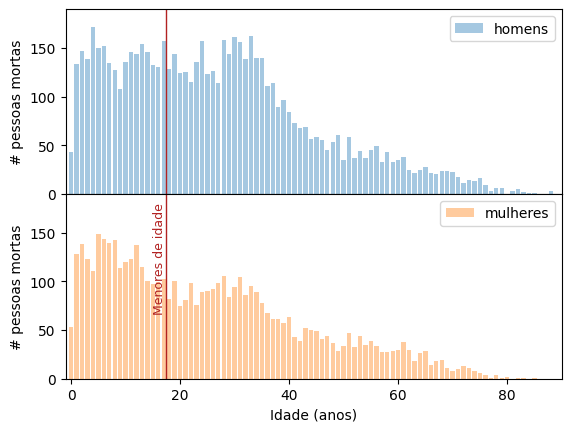

In [4]:
# Vendo os dados em um gráfico:
ag.graf_barra_2(n_mortos_df, ylabel='# pessoas mortas', ylim=[0,190], alpha=0.4)
pl.xlabel('Idade (anos)')
for i in range(1,3):
    pl.subplot(2, 1, i)
    pl.axvline(17.5, color='firebrick', linewidth=1)
pl.text(17.5, 70, 'Menores de idade', rotation=90, ha='right', color='firebrick', fontsize=9)
pl.show()

Os dados sobre a pirâmide etária se refere à toda a população de Gaza (estimativa de 2023) e tem a mesma forma. 
Os números de pessoas não são inteiros pois se trata de uma estimativa: 

In [5]:
# A cara dos dados:
piramide_df

,n_homens,n_mulheres
idade,,
0,27751.28,26097.97
1,27751.28,26097.97
2,27751.28,26097.97
3,27801.81,26149.60
4,27842.41,26195.69
...,...,...
88,218.69,304.05
89,179.82,253.37
90,138.94,202.69


Vamos ver a pirâmide etária em um gráfico:

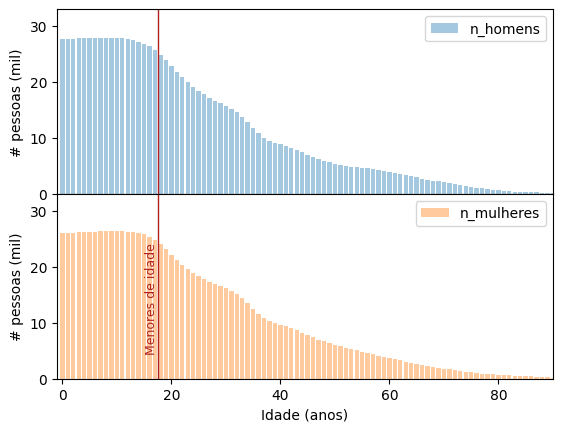

In [6]:
# Vendo os dados em um gráfico:
ag.graf_barra_2(piramide_df / 1000, ylabel='# pessoas (mil)', ylim=[0, 33], alpha=0.4)
pl.xlabel('Idade (anos)')
for i in range(1,3):
    pl.subplot(2, 1, i)
    pl.axvline(17.5, color='firebrick', linewidth=1)
pl.text(17.5, 5, 'Menores de idade', rotation=90, ha='right', color='firebrick', fontsize=9)
pl.show()

Já podemos notar que a distribuição das mortes por idade e sexo não é radicalmente diferente da distribuição da população como um todo.

<a id="modelo"></a>
## 2. Criando um modelo estatístico motivado

Vamos elaborar um _modelo estatístico motivado pela realidade_ que descreva a distribuição das mortes em Gaza por idade e sexo. Vamos explicar o que queremos dizer 
com cada um desses termos:
* **Modelo:** é uma fórmula matemática que representa a ideia que temos da realidade. Essa fórmula quantifica o valor esperado para uma
certa quantidade chamada de _variável dependente_ (neste caso, o número de mortes) a partir do valor de _variáveis independentes_ (neste caso, a idade e o sexo).
Essa fórmula depende de suposições que fazemos a respeito da realidade, que são traduzidas para matemática e podem depender de outras quantidades, chamadas de _parâmetros_.
* **Estatístico:** este adjetivo está aqui para lembrar que esse modelo apenas quantifica uma tendência para a variável dependente. O valor real dessa variável possui uma componente aleatória -- isto é, que é impossível de prever pois depende de muitos fatores e acasos que são imprevisíveis.
* **Motivado pela realidade:** com este termo queremos enfatizar que a forma e flexibilidade do modelo possui uma motivação dada pela realidade que ele busca representar. Poderíamos chamar esse tipo de modelo de "modelo mecanicista" (pois busca descrever os mecanismos por trás do processo que gerou os dados) ou "modelo causal" (pois se basearia nas causas dos dados). Esse tipo de modelo é diferente dos modelos de _aprendizado de máquina_, muito usados em ciência de dados. Ao contrário de modelos motivados, os modelos de aprendizado de maquina tipicamente servem apenas para descrever a tendência observada nos dados, sem fazer qualquer suposição a respeito de como aqueles dados foram gerados ou de qual o processo que está por trás desses dados. Esse tipo de modelo pode ser aplicado a quaisquer dados e muitas vezes são tão flexíveis que conseguem se ajustar a qualquer relação possível entre variáveis independentes e dependentes. Exemplos de modelos de aprendizado de máquina são as
[árvores de decisão](https://didatica.tech/como-funciona-o-algoritmo-arvore-de-decisao/) e as
[redes neurais](https://sites.icmc.usp.br/andre/research/neural/).

Para construir nosso modelo, vamos nos fundamentar no fato de que **processos diferentes de geração dos dados geram "assinaturas" diferentes nos dados**.
Para o nosso caso em estudo, isso significa que diferentes causas de morte (ou processos que levam ao registro de mortes nos hospitais) geram distribuições diferentes do número de pessoas por idade e sexo. Por exemplo: no caso de mortes causadas por complicações no parto, apenas mulheres são afetadas, e de maneira mais significativa as mulheres adultas (mas não idosas). Já no caso de mortes por câncer, a probabilidade recai sobre pessoas mais velhas. Nas periferias do Brasil, as mortes por assassinato acontecem majoritariamente com adolescentes e jovens homens, a partir de uns 15 anos.

### 2.1. Modelo de duas componentes para as mortes em Gaza

Vamos assumir que existem apenas duas causas principais das mortes relacionadas aos ataques de Israel a Gaza:

1. **Ataques indiscriminados**, que matam qualquer pessoa (isto é, de qualquer idade ou sexo) com igual probabilidade.
   Um exemplo de ataque com essas características seria o uso de bombas do tipo [bunker buster](https://pt.wikipedia.org/wiki/Arma_antibunker),
   de alto poder destrutivo, em áreas residenciais muito densas. Essas armas foram utilizadas em Gaza
   (veja, por exemplo, [reportagem da CNN Brasil](https://www.cnnbrasil.com.br/internacional/israel-lancou-centenas-de-bombas-de-907-kg-em-gaza-volume-nao-visto-desde-a-guerra-do-vietna-mostra-analise/)). Como qualquer pessoa (bebês, crianças, jovens, adultos, idosos, homens e mulheres) podem ser mortos com igual probabilidade, a distribuição de mortes por idade e sexo resultante desse ataque é igual à distribuição da população de Gaza, ou seja, é proporcional à pirâmide etária de Gaza. Essa é a assinatura desse tipo de causa de morte.

2. **Ataques focados:** esses seriam ataques direcionados a pessoas com características parecidas com as de combatentes do Hamas. Na grande maioria das organizações militares, algo próximo de [90% dos combatentes são homens](https://www.gov.br/defesa/pt-br/arquivos/ensino_e_pesquisa/defesa_academia/cadn/artigos/XIII_cadn/mulheres_nas_forcas_armadas_desenvolvimento_historicojuridico_da_participacao_feminina_na_defesa_nacional_final_1.pdf). Um estudo da pesquisadora [Devorah Margolin](https://www.washingtoninstitute.org/about/press-room/press-release/counterterrorism-expert-devorah-margolin-joins-washington-institute) mostrou que cerca de [84% de ataques do Hamas são realizados por homens](https://extremism.gwu.edu/sites/g/files/zaxdzs5746/files/The%20Changing%20Roles%20of%20Women%20in%20Violent%20Islamist%20Groups.pdf). Portanto, esperamos que ataques focados resultem em muito mais mortes de homens do que de mulheres. Além disso, [organizações militares são compostas principalmente por jovens adultos](https://www.statista.com/statistics/232711/number-of-active-duty-us-defense-force-personnel-by-age/), e não crianças pequenas (embora a participação de adolescentes possa existir). Isso nos leva a concluir que ataques focados devem vitimar principalmente homens adultos jovens, poucos idosos e nenhuma criança pequena.

Assim, nosso modelo para as mortes em Gaza $M$ por idade $i$ e sexo $s$ considera que parte das mortes decorre de ataques indiscriminados e parte decorre de ataques focados:

$$M(i,s) = M_{\mathrm{ind}}(i, s) + M_{\mathrm{foc}}(i, s) = M_{\mathrm{tot}}\left[f_{\mathrm{g}}I(i, s) + (1 - f_{\mathrm{g}})F(i, s)\right].$$

Na equação acima, $M_{\mathrm{tot}}$ é o número total de mortes registradas nos nossos dados e $f_{\mathrm{g}}$ é a fração de mortes $M_{\mathrm{tot}}$ que foram indiscriminadas (ou generalizadas). $I(i,s)$ é a distribuição normalizada de mortes indiscriminadas, que segue a pirâmide etária de Gaza; e $F(i, s)$ é a distribuição normalizada de mortes focadas. Uma distribuição normalizada é aquela para a qual:

$$\sum_{i}\sum_{s}F(i, s) = 1$$

**Modelando os ataques focados**

Não sabemos exatamente como é a distribuição de mortes por ataques focados $F(i,s)$, apenas suas características básicas: 

1. ela deve ser diferente para homens e mulheres;
2. não deve contemplar crianças pequenas;
3. deve ter um pico para adultos jovens; e
4. deve cair lentamente para pessoas mais velhas.

Várias distribuições de probabilidade podem abarcar essas características. Uma delas é a [lognormal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_log-normal). Você pode ver a cara da distribuição no gráfico abaixo:  

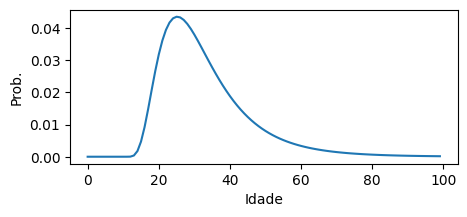

In [11]:
# Calcula os parâmetros da lognormal a partir da média, desvio padrão e offset (mais intuitivo):
# O offset é uma translação da distribuição para a direita (se offset < 0) ou esquerda (se offset > 0)
ln_pars = su.to_lognormal_pars(33, 13, -10) # Na ordem: média, desvio padrão e offset.

# Cria um vetor de idades:
i = np.arange(0, 100)
# Calcula a PDF para as idades (i < -offset sai como nan, precisa ser zero):
pdf = np.nan_to_num(su.lognormal_pdf(i, *ln_pars))

# Cria um gráfico da distribuição lognormal:
pl.figure(figsize=(5,2))
pl.plot(i, pdf)
pl.xlabel('Idade')
pl.ylabel('Prob.')
pl.show()

Para simplificar o modelo, vamos assumir que a forma da distribuição de mortes por ataques focados é igual para homens e mulheres. A única coisa que mudaria é a proporção entre essas mortes, que esperamos ser maior para homens. Então, o modelo final para as mortes em Gaza fica assim:

$$M(i,s) = M_{\mathrm{tot}}\left\{f_{\mathrm{g}}I(i, s) + (1 - f_{\mathrm{g}})\left[f_{\mathrm{mulher}}\delta_{sm} + (1 - f_{\mathrm{mulher}})\delta_{sh}\right]L(i)\right\}.$$

Na equação acima, $f_{\mathrm{mulher}}$ é a fração dos ataques focados que são direcionados a mulheres, $\delta_{ij}$ é o [Delta de Kronecker](https://pt.wikipedia.org/wiki/Delta_de_Kronecker), seus índices $m$ e $h$ representam as categorias "mulheres" e "homens", respectivamente, e $L(i)$ é uma distribuição lognormal.

A função abaixo implementa nosso modelo. Por padrão, ela pega como entrada 5 parâmetros: 
$f_{\mathrm{g}}$, $f_{\mathrm{mulher}}$, e a média, desvio padrão e idade mínima (que é menos o offset) das mortes por ataques focados. 
A função então retorna 3 vetores, cada um com as frações das mortes totais que o modelo espera para cada idade e sexo. O primeiro vetor se refere às mortes decorrentes de ataques indiscriminados; o segundo, às decorrentes de ataques focados; e o terceiro contém as frações previstas pelo modelo completo. A função pode receber outros parâmetros caso seja de interesse mudar os padrões.

In [3]:
def prob_morte(fg, pir_df, f_mulher, mH, sH, iminH, mM=None, sM=None, iminM=None, idade_min=0, idade_max=92, pymc=True):
    """
    Calcula as probabilidades de morte em um modelo de duas componentes 
    de ataques: gerais (indiscriminados) e focados em potenciais 
    combatentes.

    As mortes por ataques gerais são modeladas na proporção da pirâmide 
    etária e distribuição por sexo da população.

    As mortes por ataques focados são modeladas como uma distribuição 
    lognormal.

    Parâmetros
    ----------
    fg : float
        Fração das mortes decorrentes de ataques gerais.
    pir_df : DataFrame
        Pirâmide etária com fração da pop. total em cada idade (linha) e 
        sexo (coluna). Os índices devem ser idades em anos (int) e as 
        colunas devem ser 'f_homens' e 'f_mulheres'. Deve cobrir de 
        `idade_min` a `idade_max`.
    f_mulher : float
        Fração das mortes em ataques focados que são de mulheres. Se os 
        ataques só atingirem combatentes, essa deve ser a fração dos 
        combatentes que são mulheres.
    mH : float
        Média da distribuição de idade das mortes de homens por ataques 
        focados.
    sH : float
        Desvio padrão da distribuição de idade das mortes de homens por 
        ataques focados.
    iminH : float
        Idade mínima das mortes de homens decorrentes de ataques focados.
    mM : float
        Mesmo que `mH`, mas para mulheres. Se for None, copia o valor dos 
        homens.
    sM : float
        Mesmo que `sH`, mas para mulheres. Se for None, copia o valor dos 
        homens.
    iminM : float
        Mesmo que `iminH`, mas para mulheres. Se for None, copia o valor 
        dos homens.
    idade_min : int
        Idade mínima para o cálculo das probabilidades de morte.
    idade_max : int
        Idade máxima para o cálculo das probabilidades de morte.
    pymc : bool
        O pacote de Python pyMC, que vamos usar para ajustar o modelo aos
        dados, precisa que partes do código sejam escritas com suas próprias
        funções. Por outro lado, para fazermos gráficos das previsões do 
        modelo, precisamos usar funções do numpy. Esta variável serve para 
        definir quais funções utilizar.
    
    Retornos
    --------
    geral : array 1D de floats (2 * n_idade,)
        n_idade = (idade_max - idade_min + 1)
        Probabilidades de morte por ataques gerais para cada idade de 
        homens (geral[:n_idade]) e para cada idade de mulheres 
        (geral[n_idade:]).
    focado : array 1D de floats (2 * n_idade,)
        Probabilidades de morte por ataques focados para cada idade de 
        homens (focado[:n_idade]) e para cada idade de mulheres 
        (focado[n_idade:]).
    probs : array 1D de floats (2 * n_idade,)
        Probabilidades de morte do modelo completo para cada idade de 
        homens (probs[:n_idade]) e para cada idade de mulheres 
        (probs[n_idade:]).
    """
    
    # Usa o mesmo modelo focado para homens e mulheres se específico não for definido:
    if mM == None:
        mM = mH
    if sM == None:
        sM = sH
    if iminM == None:
        iminM = iminH    

    # Pirâmide etária (ataques gerais, indiscriminados):
    i   = np.arange(idade_min, idade_max + 1, dtype=np.int64)
    pir = np.concatenate((pir_df['f_homens'].loc[i].values, pir_df['f_mulheres'].loc[i].values))
        
    # Calcula parâmetros da PDF de morte enquanto alvo (ataque focado):
    muH, sigH, shiftH = su.to_lognormal_pars(mH, sH, -iminH)
    muM, sigM, shiftM = su.to_lognormal_pars(mM, sM, -iminM)
    
    # Quando rodamos o pyMC, precisamos usar algumas funções suas no lugar das do numpy:
    if pymc == True:
        # Homens:
        lnpdfH = su.lognormal_pdf(pm.math.clip(i + shiftH, 1e-12, 1e3), muH, sigH, 0)  # Prob. por idade.
        PfaltH = (1 - pm.math.sum(lnpdfH, keepdims=True)) / len(i)                     # Prob. faltante por erro de discretização da PDF
        alvosH = (1 - f_mulher) * (lnpdfH + PfaltH)                                    # Distribui a prob. igualmente (só é tudo bem se for pouca coisa)
        # Mulheres:
        lnpdfM = su.lognormal_pdf(pm.math.clip(i + shiftM, 1e-12, 1e3), muM, sigM, 0)
        PfaltM = (1 - pm.math.sum(lnpdfM, keepdims=True)) / len(i) 
        alvosM = f_mulher * (lnpdfM + PfaltM)
        # Ambos:
        alvos  = pm.math.concatenate((alvosH, alvosM))
    
        # Esse código deve ser igual ao de cima (trocando pm por np em alguns lugares):
    else:
        # Homens:
        lnpdfH = su.lognormal_pdf(np.clip(i + shiftH, 1e-12, 1e3), muH, sigH, 0)
        PfaltH = (1 - np.sum(lnpdfH, keepdims=True)) / len(i)
        alvosH = (1 - f_mulher) * (lnpdfH + PfaltH)
        # Mulheres:
        lnpdfM = su.lognormal_pdf(np.clip(i + shiftM, 1e-12, 1e3), muM, sigM, 0)
        PfaltM = (1 - np.sum(lnpdfM, keepdims=True)) / len(i) 
        alvosM = f_mulher * (lnpdfM + PfaltM)
        # Ambos:
        alvos  = np.concatenate((alvosH, alvosM))

    # Distribui os pesos das componentes
    geral  = fg * pir
    focado = (1 - fg) * alvos  
    # Modelo completo:
    probs  = geral + focado 
    
    return geral, focado, probs

### 2.2. Vizualizando o modelo e o comparando com os dados

Nosso modelo precisa da distribuição normalizada da população de Gaza por idade e sexo. Vamos calcular isso abaixo:

In [4]:
# Normalização da pirâmide etária:
pir_norm_df = pd.DataFrame()
pop_total   = piramide_df.sum().sum()
pir_norm_df['f_homens']   = piramide_df['n_homens']   / pop_total
pir_norm_df['f_mulheres'] = piramide_df['n_mulheres'] / pop_total

Agora, vamos ver quais são as previsões do modelo e compará-las com os dados. **Nós deixamos os parâmetros com valores inadequados de propósito**. Você pode mudar os parâmetros do modelo para ver como eles mudam as previsões e para ver quais valores de parâmetros que melhor descrevem os dados:

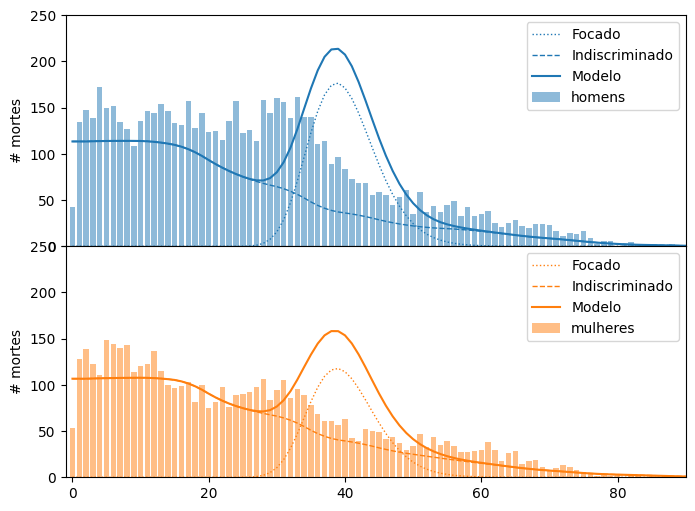

In [5]:
# Parâmetros do modelo:
f_ind = 0.70        # Fração das mortes que são causadas por ataques indiscriminados.
f_mulheres = 0.40   # Fração dos ataques focados que visam mulheres.
idade_media = 40    # Idade média das mortes causadas por ataques focados.
variacao_idade = 5  # Desvio padrão da idade das mortes causadas por ataques focados.
idade_minima   = 10 # Idade abaixo da qual a probabilidade da morte ser causada por ataque focado é zero.

# Calcula fração das mortes para cada idade e sexo:
geral, focado, probs = prob_morte(f_ind, pir_norm_df, f_mulheres, idade_media, variacao_idade, idade_minima, pymc=False)

# Cria gráfico que compara o modelo com os dados:
N_mortes = n_mortos_df[['homens', 'mulheres']].sum().sum()
pl.figure(figsize=(8,6))
ag.graf_barra_2(n_mortos_df[['homens', 'mulheres']], ylabel='# mortes', ylim=[0,250])
su.plot_esperado(N_mortes, focado, 'Focado', linewidth=1, linestyle='dotted')
su.plot_esperado(N_mortes, geral, 'Indiscriminado', linewidth=1, linestyle='--')
su.plot_esperado(N_mortes, probs, 'Modelo')

Duas coisas merecem ser destacadas sobre a comparação acima:
* Como podemos ajustar a média, o desvio padrão e o offset das mortes deccorentes de ataques focados, existe grande flexibilidade para atribuir mortes a esse tipo de ataque. Nós não estamos exigindo, a priori, que esses valores sejam algum específico para que seja feita essa atribuição. Por outro lado, não há flexibilidade alguma para as mortes associadas a ataques indiscriminados. Isso faz com que o modelo seja mais cuidadoso na atribuição de mortes a ataques indiscriminados do que a ataques focados.
* Notamos que as mortes de bebês de zero anos está muito abaixo das mortes de bebês de 1 ano. Esse tipo de variação abrupta parece mais com algum problema de registro dos dados do que uma característica real do processo que leva à morte dos bebês. Por esse motivo, quando formos ajustar o modelo aos dados, vamos ignorar as mortes para bebês de zero anos.

## 3. Ajustes de modelos estatísticos a dados

Conforme mencionado na seção [2. Criando um modelo estatístico motivado](#modelo), nenhum modelo será capaz de prever ou descrever 
exatamente dados reais pois estes são gerados por uma quantidade muito grande de processos complexos e causas combinadas que são imprevisíveis. 
Por isso, o melhor que um modelo pode fazer é prever um _valor esperado_ para os dados e um tamanho de variabilidade aceitável. Abaixo damos um exemplo simples dessa ideia.

### 3.1. Exemplo simples: jogando cara ou coroa

Digamos que vamos jogar "[Cara ou Coroa](https://pt.wikipedia.org/wiki/Cara_ou_coroa)" 10 vezes com uma moeda. Não temos como saber exatamente quantas vezes a moeda vai cair em "cara". Por isso, o melhor que podemos fazer é especificar um valor esperado, ou tendência. Por exemplo: como acreditamos que a moeda não é adulterada, a melhor previsão que podemos fazer é que a moeda vai cair _aproximadamente_ metade das jogadas em "cara", ou seja, 5 vezes. Esse é o _valor esperado do nosso modelo_.

Agora, nos falta definir qual a variabilidade que seria esperada. Por exemplo: se a moeda cair 6 vezes em "cara", vamos achar isso estranho, inesperado? Não. Porém, se a moeda cair 10 vezes em "cara", vamos achar que tem algo estranho aí. Isto é: o nosso modelo (no qual a moeda tem 50% de chance de cair em "cara") não seria muito bom. Teríamos que modificar nossa suposição sobre o jogo (talvez a moeda seja adulterada ou tenha algum truque acontecendo).

Por incrível que pareça, é possível quantificar a "estranheza" de cada resultado possível dessas 10 jogadas. Na verdade, o que podemos quantificar é a _probabilidade_ de 10 jogadas da moeda resultarem em um certo número de "caras". Nesse caso da moeda, essa probabilidade é dada pela [distribuição binomial](https://www.escoladnc.com.br/blog/guia-completo-da-distribuicao-binomial-conceitos-formulas-e-aplicacoes/). Essa distribuição parte da suposição que, para cada jogada, a moeda tem uma certa probabilidade $p$ de dar "cara". Além disso, também assumimos que essa probabilidade $p$ não muda de uma jogada para outra e que o resultado de uma jogada não influencia o resultado de outra. A partir dessas suposições, é possível saber a probabilidade de termos $k$ "caras" em $n$ jogadas.

Vamos exemplificar com duas jogadas da moeda ($n=2$). Nesse caso tempos 4 possibilidades de resultado:

<table style="text-align: center; vertical-align: middle; border: 1px solid black; border-collapse: collapse;">
    <tr><th><h3>Caso</h3></th><th><h3>1a jogada</h3></th><th><h3>2a jogada</h3></th><th><h3>Prob. desse resultado</h3></th><th><h3>Prob. se $p = 0.5$</h3></th></tr>
    <tr><td><h3>1</h3></td><td><img src="imagens/moeda_cara.png" width=70></td><td><img src="imagens/moeda_cara.png" width=70></td><td><h4>$p \cdot p$</h4></td><td><h4>0.25</h4></td></tr>
    <tr><td><h3>2</h3></td><td><img src="imagens/moeda_cara.png" width=70></td><td><img src="imagens/moeda_coroa.png" width=70></td><td><h4>$p \cdot (1-p)$</h4></td><td><h4>0.25</h4></td></tr>
    <tr><td><h3>3</h3></td><td><img src="imagens/moeda_coroa.png" width=70></td><td><img src="imagens/moeda_cara.png" width=70></td><td><h4>$(1-p) \cdot p$</h4></td><td><h4>0.25</h4></td></tr>
    <tr><td><h3>4</h3></td><td><img src="imagens/moeda_coroa.png" width=70></td><td><img src="imagens/moeda_coroa.png" width=70></td><td><h4>$(1-p) \cdot (1-p)$</h4></td><td><h4>0.25</h4></td></tr>
</table>

Como tanto no caso 2 quanto no 3 temos uma "cara", a probabilidade de termos uma "cara" é a soma das probabilidades desses dois casos. Se $p=0.5$, então a chance de termos uma "cara" é de 50%, 
maior que a probabilidade de zero ou duas "caras" (que são de 25\% cada). A distribuição binomial é uma fórmula que calcula esse mesmo resultado para quaisquer número de jogadas $n$ e de "caras" $k$.

Para o caso de 10 jogadas, vamos ver abaixo a probabilidade de obtermos cada número de "caras". Você pode mudar os parâmetros $p$ e $n$ para ver o impacto nos resultados:

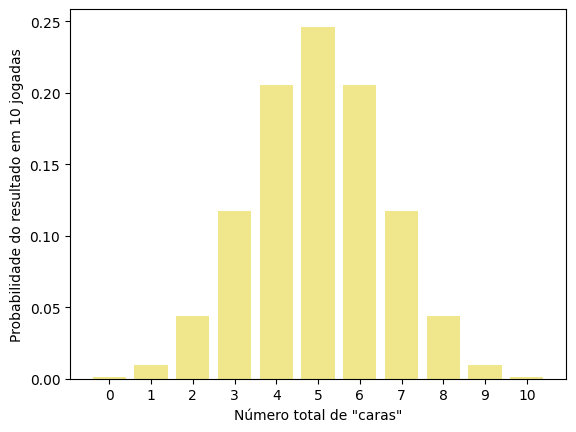

In [14]:
p = 0.5 # Probabilidade de obter "cara" em uma única jogada.
n = 10  # Número de jogadas.
# Calcula a distribuição de probabilidade para cada número de "caras" que podem ser obtidos:
k = np.arange(0, n + 1)
prob_cara = binom.pmf(k, n, p)
# Gráfico:
pl.bar(k, prob_cara, color='khaki')
# Formatação:
pl.xticks(k,k)
pl.ylabel('Probabilidade do resultado em {} jogadas'.format(n))
pl.xlabel('Número total de "caras"')
pl.show()

Em 10 jogadas de uma moeda "justa" (com 50% de chance de cair em "cara"), a probabilidade do resultado ser 9 ou mais "caras" é de menos de 2%. Então se esse resultado aparecer, temos motivo para ficarmos desconfiados com a moeda!

**E onde o ajuste do modelo entra nisso?**

No gráfico acima, nós especificamos uma probabilidade $p$ da moeda dar "cara" e o número de jogadas $n$. A partir daí, calculamos a probabilidade de obtermos $k$ "caras". No caso de uma observação da realidade, entretanto, o que normalmente temos é o inverso: nós já vimos que saíram $k$ caras em $n$ jogadas, e o que queremos saber é qual parâmetro $p$ que melhor explicaria a observação desse valor $k$. Para isso, vamos utilizar a mesma função do gráfico acima: `binom.pmf(k, n, p)`. Mas, agora, vamos manter $k$ em um valor fixo e variar $p$ para achar os valores que melhor explicariam esse valor $k$ que já observamos. Essa é a chamada [função de verossimilhança](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_verossimilhan%C3%A7a):

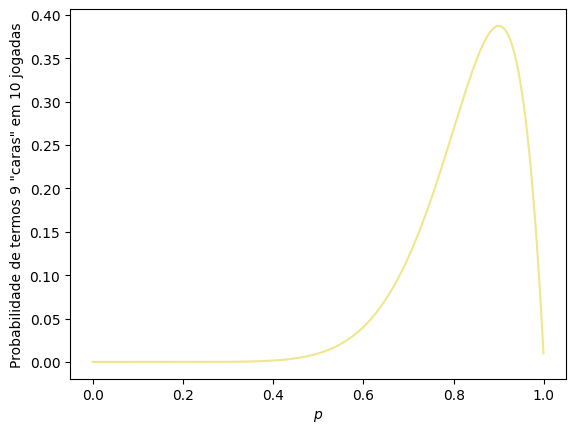

In [31]:
n = 10  # Número de jogadas.
k =  9  # Número observado de "caras".

# Calcula a distribuição de probabilidade para cada número de "caras" que podem ser obtidos:
dp = 0.001 
p  = np.arange(0, 1, dp)
prob_cara = binom.pmf(k, n, p)
# Gráfico:
pl.plot(p, prob_cara, color='khaki')
# Formatação:
pl.ylabel('Probabilidade de termos {:} "caras" em {:} jogadas'.format(k, n))
pl.xlabel('$p$')
pl.show()

O gráfico acima mostra que a probabilidade de obtermos $k=9$ "caras" em $n=10$ jogadas é muito menor se $p$ for 0.5 do que se $p$ for 0.75 ou 0.9. Para ajustarmos o modelo aos dados 
(isto é, para descobrir os parâmetros que melhor explicariam os dados), podemos utilizar o [método de máxima verossimilhança](https://pt.wikipedia.org/wiki/M%C3%A1xima_verossimilhan%C3%A7a), 
isto é, de buscar o ponto de máximo da função de verossimilhança.

Neste tutorial nós vamos adotar um outro método de ajuste parecido, o da [inferência Bayesiana](https://en.wikipedia.org/wiki/Bayesian_inference). A principal diferença com o método de máxima verossimilhança é a seguinte.

A função de verossimilhança nos diz quão provável são os dados se os parâmetros do modelo forem os especificados. Entretanto, ela não leva em conta se esses valores especificados dos parâmetros são os mais adequados segundo nossos conhecimentos prévios. Por exemplo: se examinarmos a moeda antes das jogadas a concluirmos que ela é, provavelmente, uma moeda comum, seria muito estranho supor que sua chance de dar "cara" é de 90% ($p=0.9$). Portanto, diante do resultado observado ($k=9$), faria mais sentido estimar que o valor mais provável para $p$ é um pouco menor do que o do máximo da função de verossimilhança; e que ao menos parte do resultado observado decorreu da sorte. Isso é formalizado pelo [Teorema de Bayes](https://pt.wikipedia.org/wiki/Teorema_de_Bayes):

$$P(p|k,n) = \frac{P(p|n)P(k|p,n)}{P(k|n)}$$
Na equação acima, $P(A|B)$ significa "a probabilidade de termos o valor $A$ dado que sabemos um valor $B$". Então, $P(k|p,n)$ significa "a probabilidade de termos $k$ 'caras' dado que jogamos a moeda $n$ vezes e a chance da moeda cair em 'cara' é $p$". Isso é exatamente a função de verossimilhança (e o que o gráfico de barras acima mostra). Já $P(p|k,n)$ significa "a probabilidade da moeda ter a chance $p$ de dar 'cara' dado que jogamos a moeda $n$ vezes e ela caiu em 'cara' $k$ vezes". É isso que queremos saber! Agora só falta entender os outros termos da equação.

$P(p|n)$, chamado de _prior_, é "a probabilidade da moeda ter um valor $p$ dado que apenas sabemos que a jogamos $n$ vezes" (isto é, não sabemos o resultado $k$). Essa é a informação _a priori_  que já tínhamos sobre a moeda, mencionada acima. Essa função de $p$ pode ser especificada com base em dados observados anteriormente (em experimentos anteriores) ou com base no nosso entendimento do contexto, meio que num chute bem fundamentado.

Já $P(k|n)$ é chamado de "evidência do modelo", e é mais difícil de interpretar. Por isso, esse valor (que é uma constante pois apenas depende de números observados, $k$ e $n$) é normalmente calculado a partir da normalização de $P(p|k,n)$:

$$\int P(p|k,n) \mathrm{d}p = 1 \;\rightarrow\; P(k|n) = \int P(p|n)P(k|p,n)\mathrm{d}p$$

Em outras palavras, a probabilidade de $p$ ter qualquer um dos seus possíveis valores é 100%.

No nosso exemplo, podemos representar nossa expectativa $P(p|n)$ (chamada de Prior e derivada da inspeção prévia da moeda) pela função abaixo (uma [distribuição beta](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_beta)). Você pode alterar os parâmetros e ver o efeito que eles tem na distribuição do Prior. Além disso, o gráfico compara a função de verossimilhança $P(k|p,n)$ com o resultado $P(p|k,n)$ de sua multiplicação pelo Prior, chamado de distribuição probabilidade à posteriori (ou Posterior).

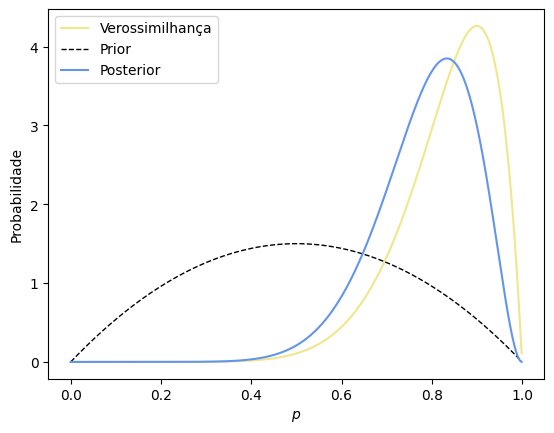

In [57]:
# Gráfico
prior = sc.stats.distributions.beta.pdf(p, 2, 2)

# Cálculo da distribuição de probabilidade à posteriori:
posterior = prior * prob_cara
norm_post = posterior.sum() * dp
# É preciso normalizar a probabilidade para que ela totalize 100%:
posterior = posterior / norm_post 

# Cálculo da normalização da Verossimilhança, para facilitar a comparação:
norm_prob = prob_cara.sum() * dp

# Gráficos:
pl.plot(p, prob_cara / norm_prob, color='khaki', label='Verossimilhança')
pl.plot(p, prior, color='k', linewidth=1, linestyle='--', label='Prior')
pl.plot(p, posterior, color='cornflowerblue', label='Posterior')
# Formatação:
pl.ylabel('Probabilidade'.format(k, n))
pl.xlabel('$p$')
pl.legend()
pl.show()

Vemos que o efeito do Prior sobre nossa estimativa de $p$, nesse caso, é deslocar os valores mais prováveis para números mais próximos de 0.5. Mas, ainda assim, o resultado $k=9$ é tão estranho que ainda é pouco provável que a moeda seja realmente justa.

## MCMC para estimar parâmetros do modelo

In [10]:
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Usando MCMC para definir o prior das combatentes mulheres

Para exemplificar como o ajuste de um modelo a dados é feito com essa técnica, vamos aplicá-la a um caso mais simples: a medição da probabilidade de um ataque do Hamas ser realizado por uma mulher a partir da contagem de ataques realizados por homens e mulheres entre 13 de setembro de 2015 e 23 de janeiro de 2016. Esse resultado será usado na nossa análise posterior.

In [11]:
# Dados:
total_ataques = 170
ataques_mulheres = 27
# Cria modelo
with pm.Model() as mulher_model:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    prob_mulher = pm.Flat('prior_mulher')
    
    # Cria Likelihood:
    #obs_counts = pair_counts.reshape(1, len(pair_counts))
    gen_counts = pm.Binomial('ataques_fem', n=total_ataques, p=prob_mulher, observed=[ataques_mulheres])

In [12]:
# Amostra modelo com MCMC:
with mulher_model:
    idata = pm.sample(draws=2500)
prior_mulher_sample = su.get_chains(idata, 'prior_mulher')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior_mulher]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
# Aproxima a distribuição por uma Gaussiana:
g_mulher_m = prior_mulher_sample.mean()
g_mulher_s = prior_mulher_sample.std()
frase = 'Dado que, de 170 ataques, 27 foram realizados por mulheres, estimamos que a probabilidade de um ataque ser realizado por uma mulher é de {:.1f}% +/- {:.1f}%.'
print(frase.format(g_mulher_m * 100, g_mulher_s * 100))
x = np.arange(0.05,0.30, 0.002)
y = sc.stats.norm.pdf(x, g_mulher_m, g_mulher_s)

Dado que, de 170 ataques, 27 foram realizados por mulheres, estimamos que a probabilidade de um ataque ser realizado por uma mulher é de 16.3% +/- 2.8%.


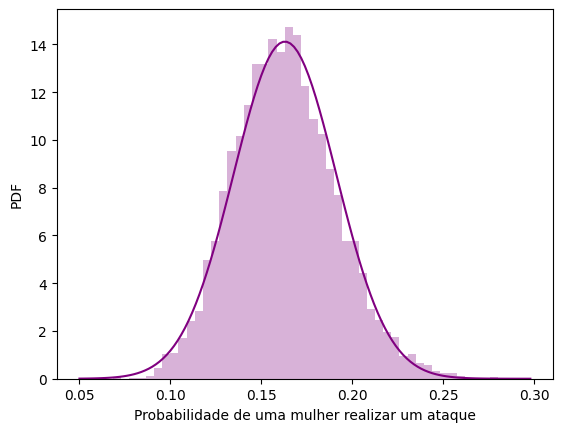

In [14]:
# Compara distribuição posterior obtida com MCMC com uma aproximação Gaussiana:
pl.hist(prior_mulher_sample, bins=50, color='purple', alpha=0.3, density=True)
pl.plot(x, y, color='purple')
pl.xlabel('Probabilidade de uma mulher realizar um ataque')
pl.ylabel('PDF')
pl.show()

### MCMC para o modelo geral

A ideia é que, como não sabemos exatamente quais os parâmetros da lognormal que descrevem os ataques focados, vamos deixá-los livres. Eles serão definidos pelos dados, durante o processo de ajuste. Ou seja: serão os dados que nos dirão quais os parâmetros que melhor lhes descrevem.

In [16]:
# Seleciona intervalo de idades que serão modeladas:
idade_min = 1
idade_max = 92
sel_mortos_df = n_mortos_df.loc[idade_min:idade_max] 
pir_sel_df = pir_norm_df.loc[idade_min:idade_max]

# Renormaliza probabilidades da pirâmide etária:
sel_prop_total = pir_sel_df.sum().sum()
pir_sel_df = pir_sel_df / sel_prop_total

# Organiza mortes observadas num vetor 1D:
conta_mortes  = np.concatenate((sel_mortos_df['homens'], sel_mortos_df['mulheres']))
# Calcula o total de mortes:
N_mortes = conta_mortes.sum()

# Cria modelo estatístico:
with pm.Model() as mortes_model:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    frac_geral  = pm.Uniform('fg', lower=0.01, upper=0.99)
    frac_mulher = pm.Normal('f_mulher', g_mulher_m, g_mulher_s*1.15)
    ln_mean     = pm.Uniform('foc_imedia', lower=20, upper=50)
    ln_dev      = pm.Uniform('foc_idev', lower=3, upper=40)
    ln_min      = pm.Uniform('foc_imin', lower=5, upper=25)

    # Calcula probabilidades de mortes por sexo e idade:
    g, f, probs = prob_morte(frac_geral, pir_sel_df, frac_mulher, ln_mean, ln_dev, ln_min, idade_min=idade_min, idade_max=idade_max)
    
    # Cria Likelihood:
    mortes_esp = pm.Multinomial('mortes_esp', n=N_mortes, p=probs, observed=conta_mortes)

In [17]:
# Amostra modelo com MCMC:
with mortes_model:
    idata = pm.sample(draws=5000)
# Coloca amostragem da prob. a posteriori dos parâmetros em um DataFrame:
chain_df = su.idata2df(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fg, f_mulher, foc_imedia, foc_idev, foc_imin]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.


## Análise dos resultados do modelo

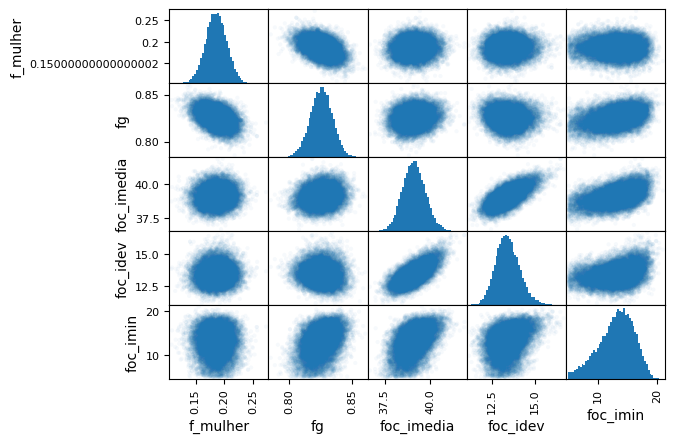

In [18]:
# Distribuição de probabilidades dos parâmetros do modelo, dadas as observações:
pd.plotting.scatter_matrix(chain_df, alpha=0.04, hist_kwds={'bins': 50})
pl.show()

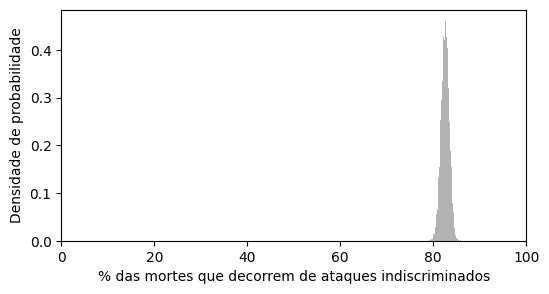

In [19]:
pl.figure(figsize=(6,3))
pl.hist(chain_df['fg'] * 100, bins=50, color='0.7', density=True)
pl.xlim([0,100])
pl.ylabel('Densidade de probabilidade')
pl.xlabel('% das mortes que decorrem de ataques indiscriminados')

pl.show()

In [20]:
# Pega valores esperados dos parâmetros do modelo:
best_fit = chain_df.mean().to_dict()

# Exibe valores esperados:
print(best_fit)

# Calcula prob. de morte de acordo com o modelo: 
geral, focado, probs = prob_morte(best_fit['fg'], pir_sel_df, best_fit['f_mulher'], best_fit['foc_imedia'], best_fit['foc_idev'], best_fit['foc_imin'], idade_min=idade_min, pymc=False)

{'f_mulher': 0.18571326484957704, 'fg': 0.825433489810871, 'foc_imedia': 39.10746023172204, 'foc_idev': 13.42611489599139, 'foc_imin': 13.100951463717232}


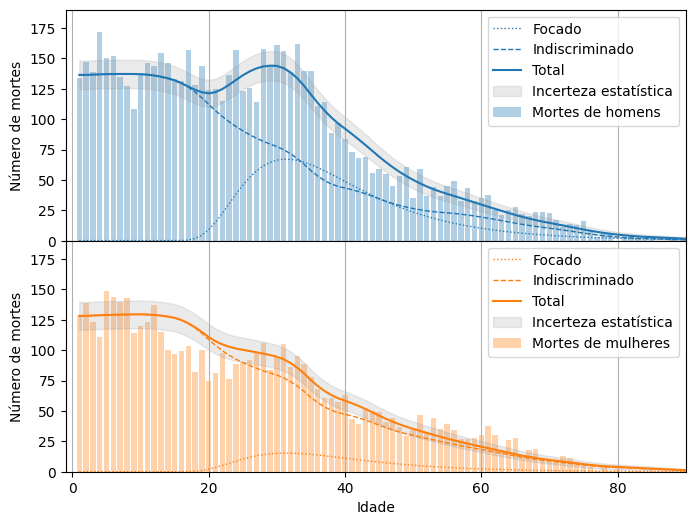

In [21]:
# Gráfico de mortes vs. modelo:
pl.figure(figsize=(8,6))
# Gráfico dos dados observados:
observacoes_df = sel_mortos_df[['homens', 'mulheres']].rename({'homens':'Mortes de homens', 'mulheres':'Mortes de mulheres'}, axis=1)
ag.graf_barra_2(observacoes_df, alpha=0.35, ylim=[0, 190], ylabel='Número de mortes', grid_axis='x')
# Gráficos do modelo:
su.plot_esperado(N_mortes, focado, 'Focado', linewidth=1, linestyle='dotted', idade_min=1)
su.plot_esperado(N_mortes, geral, 'Indiscriminado', linewidth=1, linestyle='--', idade_min=1)
su.plot_esperado(N_mortes, probs, 'Total', idade_min=1)
pl.xlabel('Idade')
# Coloca margem de erro estatístico (aproximado) do modelo:
for i in range(1,3):
    pl.subplot(2,1,i)
    y = probs[(i-1)*92:i*92] * N_mortes
    pl.fill_between(np.arange(1, 93), y - np.sqrt(y), y + np.sqrt(y), alpha=0.2, color='0.6', label='Incerteza estatística')
    pl.legend()
pl.show()

In [22]:
# Resumo em uma frase:
m_geral  = best_fit['fg'] * N_mortes
m_focado = (1 - best_fit['fg']) * N_mortes
print('Das {:,.0f} mortes registradas em hospitais, {:,.0f} são resultantes de ataques indiscriminados.'.format(N_mortes, m_geral))

Das 11,795 mortes registradas em hospitais, 9,736 são resultantes de ataques indiscriminados.


### Análise de resíduos

In [23]:
# Calcula os resíduos:
resid = conta_mortes - probs * N_mortes
resid_norm = resid / np.sqrt(probs * N_mortes)

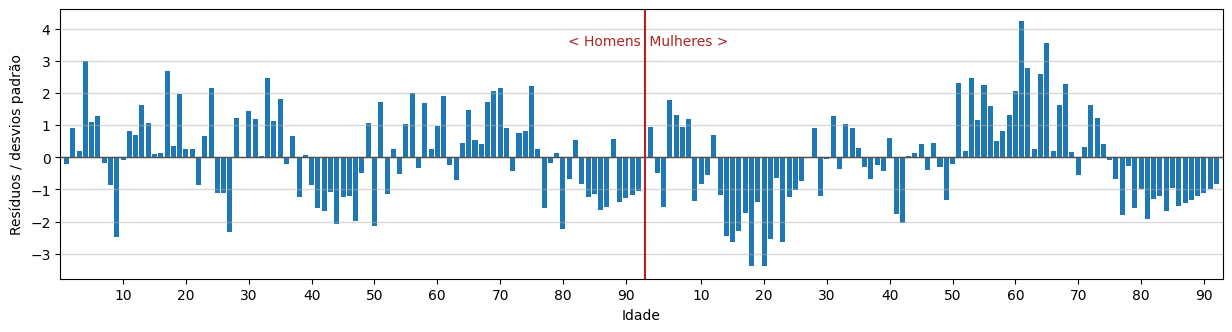

In [24]:
# Visualiza resíduos normalizados pelo desvio padrão:
pl.figure(figsize=(15,3.5))

# Plot:
bar_pos = np.arange(len(resid_norm))
pl.bar(bar_pos, resid_norm)

# Cria rótulos de idades:
n_idades = int(len(resid) / 2)
pos_h = bar_pos[:n_idades]
pos_m = bar_pos[n_idades:]
idades = np.arange(idade_min, idade_max + 1)
i_ini, i_fim, i_step = 9, 95, 10
xpos   = np.concatenate((pos_h[i_ini:i_fim:i_step], pos_m[i_ini:i_fim:i_step]))
xlabel = np.concatenate((idades[i_ini:i_fim:i_step], idades[i_ini:i_fim:i_step]))
pl.xticks(xpos, xlabel)

# Divisão homem/mulher:
pl.axvline(n_idades, color='firebrick')
pl.text(n_idades, 3.5, '< Homens ', ha='right', color='firebrick')
pl.text(n_idades, 3.5, ' Mulheres >', ha='left', color='firebrick')

# Formatação:
pl.xlim([-1, 2*92])
pl.axhline(0, color='0.3', linewidth=1)
pl.ylabel('Resíduos / desvios padrão')
pl.xlabel('Idade')
pl.grid(axis='y', linewidth=1, alpha=0.5)
pl.show()

Vemos acima que o modelo erra mais para as mulheres. Parte importante desse erro acontece na cauda da distribuição (após 50 anos). 
Trocar a distribuição lognormal por outra distribuição de cauda longa pode ajudar. 

### Teste do $\chi^2$ (Qui-quadrado)

In [25]:
chi2 = np.sum(resid_norm**2)

In [26]:
n_pontos_experimentais = len(probs)
n_parametros_modelo = 5
graus_liberdade = n_pontos_experimentais - n_parametros_modelo

chi2 / graus_liberdade

2.0332061604522944

In [27]:
# Valor-p:
sc.stats.distributions.chi2.cdf(chi2, graus_liberdade)

0.9999999999999895

O modelo não é perfeito: os desvios são maiores do que o esperado apenas por causa de flutuações estatísticas.

# Lixo

Por isso, vamos utilizar a mesma função 

A partir de um resultado obtido (por exemplo, 9 caras em 10 jogadas), podemos verificar quais valores dos parâmetros do nosso modelo (nesse caso, o valor de $p$) que teriam boas condições de explicar o resultado. De maneira mais precisa, vamos calcular a probabilidade de um certo valor $p$ levar ao resultado que observamos. Para isso, vamos utilizar o [Teorema de Bayes](https://pt.wikipedia.org/wiki/Teorema_de_Bayes):

$$P(p|k,n) = \frac{P(p|n)P(k|p,n)}{P(k|n)}$$

Na equação acima, $P(A|B)$ significa "a probabilidade de termos o valor $A$ dado que sabemos um valor $B$". Então, $P(k|p,n)$ significa "a probabilidade de termos $k$ 'caras' dado que jogamos a moeda $n$ vezes e a chance da moeda cair em 'cara' é $p$". Ora, isso é exatamente o que o gráfico acima mostra! Já $P(p|k,n)$ significa "a probabilidade da moeda ter a chance $p$ de dar 'cara' dado que jogamos a moeda $n$ vezes e ela caiu em 'cara' $k$ vezes". É isso que queremos saber! Agora só falta entender os outros termos da equação.

O termo $P(p|n)$ é chamado _prior_, e significa "a densidade de probabilidade da moeda ter a chance $p$ de dar 'cara' dado que jogamos a moeda $n$ vezes". 